# 루브릭
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.
    - 구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.
2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다.
    - seq2seq 모델 훈련 결과를 그래프로 출력해보고, validation loss 그래프가 우하향하는 경향성을 보인다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
    - 테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.
    
## 필요한 라이브러리 불러오기

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import re
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

## 데이터 불러오기

In [2]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 217975


,eng,fra,cc
150085,I have never seen anyone like him.,Je n'ai jamais vu quelqu'un comme lui.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
208052,She began doing her homework immediately after...,Elle commença à faire ses devoirs immédiatemen...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
28252,The crowd clapped.,La foule applaudit.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
151922,Put on your pajamas and go to bed.,Mettez-vous en pyjama et allez au lit.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
181295,This is the fastest car in our showroom.,C'est la bagnole la plus rapide de notre hall ...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [3]:
lines = lines[['eng', 'fra']][60000:93000] # 5만개 샘플 사용
lines.sample(5)

,eng,fra
66350,Tom hasn't arrived yet.,Tom n'est pas encore arrivé.
69466,He did not speak at all.,Il n'a absolument rien dit.
84978,You're a horrible driver.,Tu conduis très mal.
87093,I didn't mean to say that.,Je ne voulais pas dire ça.
65088,She's younger than him.,Elle est plus jeune que lui.


In [4]:
#영어와 프랑스어 분리하기
lines_np_eng= lines['eng'].to_numpy()
lines_np_fra= lines['fra'].to_numpy()
lines_np_eng

array(['You were there, right?', 'You will stay at home.',
       "You won't be punished.", ..., 'What time did you wake up?',
       'What time did you wake up?', 'What time did you wake up?'],
      dtype=object)

## 정제, 정규화, 전처리 하기
#### 필요한 함수 정의하기

In [5]:
sos_token = '<start> '
eos_token = ' <end>'


def preprocess(line, plus_token = True):
    #소문자로 변경하기
    line = line.lower().strip()
    #구두점 분리하기
    line = re.sub(r"([?.!,¿])", r" \1 ", line)
    line = re.sub(r'[" "]+', " ", line)
    line = re.sub(r"[^a-zA-Z?.!,¿]+", " ", line)
    
    line = line.strip()
    
    if plus_token == True:
        line = sos_token + line + eos_token
        
    return line

In [6]:
#토큰화 함수
def tokenize(corpus):
    tokenizer = Tokenizer(num_words=7000,
                         filters=' ',
                         oov_token='<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    
    return tensor, tokenizer

#### 영어, 프랑스어 전처리하기

In [7]:
eng_lines = []
fra_lines = []

for eng, fra in zip(lines.eng, lines.fra):
    if len(eng) == 0: continue
    if len(fra) == 0: continue
        
    eng_lines.append(preprocess(eng, plus_token=False))
    fra_lines.append(preprocess(fra))

In [8]:
np.shape(eng_lines)

(33000,)

In [9]:
eng_tensor, eng_tokenizer = tokenize(eng_lines)
fra_tensor, fra_tokenizer = tokenize(fra_lines)
fra_tensor[:10]

[[2, 15, 105, 23, 374, 34, 19, 7, 22, 8, 6, 3],
 [2, 15, 3036, 151, 78, 4, 3],
 [2, 15, 13, 1135, 8, 3723, 4, 3],
 [2, 10, 19, 347, 8, 16, 1519, 4, 3],
 [2, 15, 13, 389, 8, 16, 1519, 4, 3],
 [2, 10, 19, 1647, 8, 17, 4, 3],
 [2, 15, 443, 176, 9, 5098, 4, 3],
 [2, 15, 443, 176, 9, 35, 20, 128, 278, 4, 3],
 [2, 15, 443, 176, 9, 26, 841, 72, 4, 3],
 [2, 10, 1136, 176, 9, 10, 841, 72, 4, 3]]

#### input, target 설정하기

In [10]:
encoder_input = eng_tensor
#종료 토큰 제거
decoder_input = [[char for char in line if char != fra_tokenizer.word_index['<end>']] for line in fra_tensor]
decoder_target = [[char for char in line if char != fra_tokenizer.word_index['<start>']] for line in fra_tensor]

#### padding 추가하기

In [11]:
def pad_tensor(tensor):
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = max(num_tokens)
    maxlen = int(max_tokens)
    tensor = pad_sequences(tensor, padding='post', maxlen=maxlen)
    return tensor

In [12]:
encoder_input = pad_tensor(encoder_input)
decoder_input = pad_tensor(decoder_input)
decoder_target = pad_tensor(decoder_target)
print('영어 데이터의 크기 : ', encoder_input.shape)
print('프랑스어 입력데이터의 크기 : ', decoder_input.shape)
print('프랑스어 출력데이터의 크기 : ', decoder_target.shape)

영어 데이터의 크기 :  (33000, 10)
프랑스어 입력데이터의 크기 :  (33000, 17)
프랑스어 출력데이터의 크기 :  (33000, 17)


In [13]:
eng_vocab_size = len(eng_tokenizer.word_index)+1
fra_vocab_size = len(fra_tokenizer.word_index)+1

max_eng_seq_len = encoder_input.shape[1]
max_fra_seq_len = decoder_input.shape[1]

In [14]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이 :', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이 :', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 5795
프랑스어 단어장의 크기 : 8297
영어 시퀀스의 최대 길이 : 10
프랑스어 시퀀스의 최대 길이 : 17


#### train, test dataset 나누기

In [15]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [16]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :', encoder_input_train.shape)
print('프랑스어 학습 입력데이터의 크기(shape) :',decoder_input_train.shape)
print('프랑스어 학습 출력데이터의 크기(shape) :',decoder_target_train.shape)
print('영어 학습데이터의 크기(shape) :', encoder_input_test.shape)
print('프랑스어 학습 입력데이터의 크기(shape) :',decoder_input_test.shape)
print('프랑스어 학습 출력데이터의 크기(shape) :',decoder_target_test.shape)

영어 학습데이터의 크기(shape) : (30000, 10)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 17)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 17)
영어 학습데이터의 크기(shape) : (3000, 10)
프랑스어 학습 입력데이터의 크기(shape) : (3000, 17)
프랑스어 학습 출력데이터의 크기(shape) : (3000, 17)


## Embedding layer 사용하기
#### Encoder

In [17]:
embedding_size = 1024
hidden_size = 1024

encoder_inputs = Input(shape=(None, ), name='encoder_input')
enc_emb = Embedding(eng_vocab_size, embedding_size, input_length=max_eng_seq_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(hidden_size, dropout=0.6, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

Decoder

In [18]:
decoder_inputs = Input(shape=(None, ), name='decoder_input')
dec_emb = Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(hidden_size, dropout=0.6, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)

In [19]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [20]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 1024)   5934080     encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 1024)   8496128     decoder_input[0][0]              
______________________________________________________________________________________________

In [22]:
history = model.fit(x=[encoder_input_train, decoder_input_train],
                    y=decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test),
                    batch_size=32,
                    epochs=50)

Epoch 1/50
938/938 [==============================] - 71s 41ms/step - loss: 1.8040 - val_loss: 1.4635
Epoch 2/50
938/938 [==============================] - 37s 40ms/step - loss: 1.3175 - val_loss: 1.2313
Epoch 3/50
938/938 [==============================] - 38s 41ms/step - loss: 1.1031 - val_loss: 1.1033
Epoch 4/50
938/938 [==============================] - 39s 42ms/step - loss: 0.9498 - val_loss: 1.0316
Epoch 5/50
938/938 [==============================] - 39s 41ms/step - loss: 0.8335 - val_loss: 0.9830
Epoch 6/50
938/938 [==============================] - 39s 41ms/step - loss: 0.7461 - val_loss: 0.9571
Epoch 7/50
938/938 [==============================] - 39s 41ms/step - loss: 0.6810 - val_loss: 0.9392
Epoch 8/50
938/938 [==============================] - 39s 41ms/step - loss: 0.6319 - val_loss: 0.9390
Epoch 9/50
938/938 [==============================] - 39s 41ms/step - loss: 0.6009 - val_loss: 0.9454
Epoch 10/50
938/938 [==============================] - 39s 41ms/step - loss: 0.574

validation loss graph로 확인하기

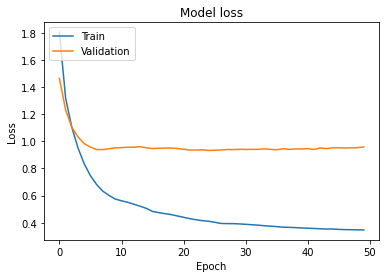

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 모델 구현하기
#### Encoder

In [24]:
encoder_model = Model(inputs=encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 1024)        5934080   
_________________________________________________________________
masking (Masking)            (None, None, 1024)        0         
_________________________________________________________________
lstm (LSTM)                  [(None, 1024), (None, 102 8392704   
Total params: 14,326,784
Trainable params: 14,326,784
Non-trainable params: 0
_________________________________________________________________


#### Decoder

In [25]:
decoder_state_input_h = Input(shape=(embedding_size,))
decoder_state_input_c = Input(shape=(embedding_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [26]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [27]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2]+decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 1024)   8496128     decoder_input[0][0]              
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1024)]       0                                            
____________________________________________________________________________________________

In [28]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <start>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['<start>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<end>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [29]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [30]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<start>']) and i!=fra2idx['<end>']):
            temp = temp + idx2fra[i] + ' '
    return temp

## 모델 평가하기

In [33]:
for seq_index in [4,153,576,1358,2883]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: i remember your father . 
정답 문장: je me rappelle de votre p re . 
번역기가 번역한 문장:  je me me ton ton to
-----------------------------------
입력 문장: i always eat breakfast . 
정답 문장: je prends toujours un petit d jeuner . 
번역기가 번역한 문장:  je tudie encore qu
-----------------------------------
입력 문장: she was very rude to him . 
정답 문장: elle a t tr s grossi re son gard . 
번역기가 번역한 문장:  elle fut l de so
-----------------------------------
입력 문장: we d make a perfect team . 
정답 문장: nous <unk> une parfaite quipe . 
번역기가 번역한 문장:  nous nous un un u
-----------------------------------
입력 문장: do you have a solution ? 
정답 문장: as tu une solution ? 
번역기가 번역한 문장:  avez tu une la ? 


모델이 생성한 문장을 하나씩 비교하면서 보겠습니다.
1.
I remember your father -> 나는 너의 아빠를 믿는다
je me me ton ton to ->나는 머리를 숙이고 있다
2.
I always eat breakfast -> 나는 항상 아침을 먹는다
je tudie encore qu ->(번역이 올바르게 되지 않음)
3.
she was very rude to him ->그녀는 그에게 매우 무례했습니다
elle fut I de so -> 그 여자는 소원이었다
4.
we d make a perfect team. ->우리는 완벽한 팀을 만들었습니다
nous nous un un u -> 단결하다
5.
do you have a solution? ->해결책이 있습니까?
avez tu une la? ->avez tu une la

다음과 같이 볼 수 있고 변역한 결과를 본다면 학습이 잘 이루어 지지 않았음을 알 수 있습니다.
학습의 하이퍼파라미터라 볼 수 있는 embedding size와 hidden_size의 값을 변경해주면서 실험을 했지만 유의미한 결과를 볼 수 없었습니다.
Exploration에서 자연어 부분을 할땐 추가적인 공부가 필요하다고 생각합니다.
다음과 같은 학습을 더 잘 하기 위해 어떤 것이 필요한지 조금 더 생각해 볼 필요가 있습니다.